# The Federalist papers

In [254]:
from collections import Counter # optional, but we found the collections.Counter object useful
import scipy.sparse as sp
import numpy as np

### TFIDF

In [208]:
def tfidf(docs):
    """
    Create TFIDF matrix.  This function creates a TFIDF matrix from the
    docs input.

    Args:
        docs: list of strings, where each string represents a space-separated
              document
    
    Returns: tuple: (tfidf, all_words)
        tfidf: sparse matrix (in any scipy sparse format) of size (# docs) x
               (# total unique words), where i,j entry is TFIDF score for 
               document i and term j
        all_words: list of strings, where the ith element indicates the word
                   that corresponds to the ith column in the TFIDF matrix
    """
    # 1. tf
    # get vocabuary dictionary: count all the words
    # dict form: {'aak':(0,3),'word':(index, count),...} 
    document_words = [d.split() for d in docs]
    voca = sorted(set(sum(document_words, [])))
    voca_dict = dict(Counter(voca))
    idx = 0
    for i in voca_dict:
        voca_dict[i] = (idx, voca_dict[i])
        idx = idx + 1
#     print(voca_dict)
    
    n = len(docs)
    p = len(voca_dict)
    
    # initialize tf sparse matrix
    row = []
    col = []
    data = []
    # computer term frequency for each document
    for i in range(n):
        doc = document_words[i]
        i_dict = dict(Counter(doc)) # count that document
        for w in i_dict:
            # each word
            row.append(i) # row index
            col.append(voca_dict[w][0]) # column index
            data.append(i_dict[w]) # counts    
            
        i = i + 1
    tf_matrix = sp.csr_matrix((data, (row, col)), shape=(n, p))

    # 2.idf 
    idf = np.log(tf_matrix.shape[0]/tf_matrix.astype(bool).toarray().sum(axis = 0))
#     print(idf)
    idf = sp.csr_matrix(idf, shape=(1, p))
    
    # 3.tfidf
    tfidf = tf_matrix.multiply(idf)
    return tfidf, voca

        

In [209]:
docs = ["hello world hello", "goodbye cruel world"]
tfidf(docs)

(<2x4 sparse matrix of type '<class 'numpy.float64'>'
 	with 3 stored elements in Compressed Sparse Row format>,
 ['cruel', 'goodbye', 'hello', 'world'])

In [226]:
data = [
    "the goal of this lecture is to explain the basics of free text processing",
    "the bag of words model is one such approach",
    "text processing via bag of words"
]

X_tfidf, words = tfidf(data)
print(X_tfidf.todense())
print(words)

[[0.         0.         1.09861229 1.09861229 1.09861229 1.09861229
  0.40546511 1.09861229 0.         0.         0.         0.40546511
  0.         0.40546511 0.81093022 1.09861229 1.09861229 0.
  0.        ]
 [1.09861229 0.40546511 0.         0.         0.         0.
  0.40546511 0.         1.09861229 0.         1.09861229 0.
  1.09861229 0.         0.40546511 0.         0.         0.
  0.40546511]
 [0.         0.40546511 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.40546511
  0.         0.40546511 0.         0.         0.         1.09861229
  0.40546511]]
['approach', 'bag', 'basics', 'explain', 'free', 'goal', 'is', 'lecture', 'model', 'of', 'one', 'processing', 'such', 'text', 'the', 'this', 'to', 'via', 'words']


In [242]:
def cosine_similarity(X):
    """
    Return a matrix of cosine similarities.
    
    Args:
        X: sparse matrix of TFIDF scores or term frequencies
    
    Returns:
        M: dense numpy array of all pairwise cosine similarities.  That is, the 
           entry M[i,j], should correspond to the cosine similarity between the 
           ith and jth rows of X.
    """
    X = X.toarray()
    tfidf_norm = X / np.linalg.norm(X, axis = 1)[:, None]
    M = tfidf_norm @ tfidf_norm.T
    return M
    
    

In [244]:
cosine_similarity(X_tfidf)

array([[1.        , 0.06796739, 0.07771876],
       [0.06796739, 1.        , 0.10281225],
       [0.07771876, 0.10281225, 1.        ]])

## Laod data

In [253]:
import re

def load_federalist_corpus(filename):
    """ Load the federalist papers as a tokenized list of strings, one for each eassay"""
    with open(filename, "rt") as f:
        data = f.read()
    papers = data.split("FEDERALIST")
    
    # all start with "To the people of the State of New York:" (sometimes . instead of :)
    # all end with PUBLIUS (or no end at all)
    locations = [(i,[-1] + [m.end()+1 for m in re.finditer(r"of the State of New York", p)],
                 [-1] + [m.start() for m in re.finditer(r"PUBLIUS", p)]) for i,p in enumerate(papers)]
    papers_content = [papers[i][max(loc[1]):max(loc[2])] for i,loc in enumerate(locations)]

    # discard entries that are not actually a paper
    papers_content = [p for p in papers_content if len(p) > 0]

    # replace all whitespace with a single space
    papers_content = [re.sub(r"\s+", " ", p).lower() for p in papers_content]

    # add spaces before all punctuation, so they are separate tokens
    punctuation = set(re.findall(r"[^\w\s]+", " ".join(papers_content))) - {"-","'"}
    for c in punctuation:
        papers_content = [p.replace(c, " "+c+" ") for p in papers_content]
    papers_content = [re.sub(r"\s+", " ", p).lower().strip() for p in papers_content]
    
    authors = [tuple(re.findall("MADISON|JAY|HAMILTON", a)) for a in papers]
    authors = [a for a in authors if len(a) > 0]
    
    numbers = [re.search(r"No\. \d+", p).group(0) for p in papers if re.search(r"No\. \d+", p)]
    
    return papers_content, authors, numbers
    
    

papers, authors, numbers = load_federalist_corpus("pg18.txt")

print(len(papers))
print(papers[0][:300])

86
after an unequivocal experience of the inefficacy of the subsisting federal government , you are called upon to deliberate on a new constitution for the united states of america . the subject speaks its own importance ; comprehending in its consequences nothing less than the existence of the union ,


In [256]:
corr = cosine_similarity(X)
corr

array([[1.        , 0.09233858, 0.06292452, ..., 0.05999312, 0.07779552,
        0.19045773],
       [0.09233858, 1.        , 0.0956748 , ..., 0.05403348, 0.10726189,
        0.11176058],
       [0.06292452, 0.0956748 , 1.        , ..., 0.09040971, 0.07130256,
        0.08910432],
       ...,
       [0.05999312, 0.05403348, 0.09040971, ..., 1.        , 0.12917947,
        0.09258297],
       [0.07779552, 0.10726189, 0.07130256, ..., 0.12917947, 1.        ,
        0.15379717],
       [0.19045773, 0.11176058, 0.08910432, ..., 0.09258297, 0.15379717,
        1.        ]])

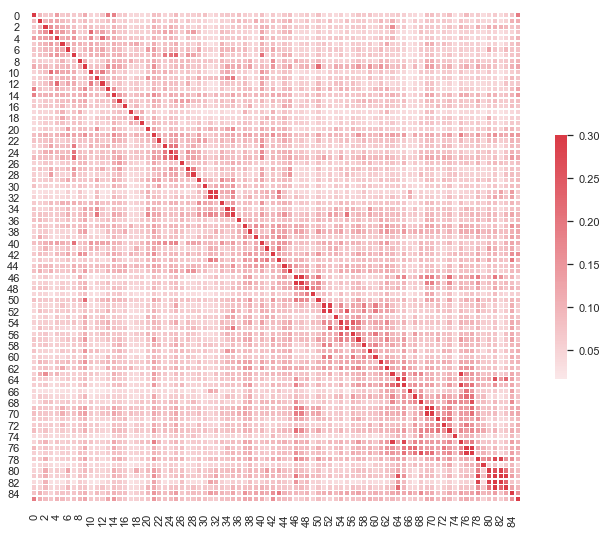

In [257]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})